## Deep Deterministic Policy Gradient
Implementation followed: Continuous control with deep reinforcement learning (arXiv:1509.02971v5)
- Memory Relay
- A3C
- Trained with a target net
- Initial exploration policy is quite important to warm up the net

In [1]:
import datetime
print(datetime.datetime.now().isoformat())

2019-07-05T12:01:39.225612


In [2]:
import numpy as np
import tensorflow as tf
from functools import partial

In [3]:
class Actor(object):
    def __init__(self, n_observation, n_action, name='actor_net'):
        self.n_observation = n_observation
        self.n_action = n_action
        self.name = name
        self.sess = None
        self.build_model()
        self.build_train()
        
    def build_model(self):
        activation = tf.nn.elu
        kernel_initializer = tf.contrib.layers.variance_scaling_initializer()
        kernel_regularizer = tf.contrib.layers.l2_regularizer(0.01)
        default_dense = partial(tf.layers.dense,\
                                activation=activation,\
                                kernel_initializer=kernel_initializer,\
                                kernel_regularizer=kernel_regularizer)
        with tf.variable_scope(self.name) as scope:
            observation = tf.placeholder(tf.float32,shape=[None,self.n_observation])
            hid1 = default_dense(observation,32)
            hid2 = default_dense(hid1,64)
            action = default_dense(hid2,self.n_action,activation=tf.nn.tanh,use_bias=False)
            trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=self.name)
        self.observation,self.action,self.trainable_vars = observation,action,trainable_vars
        
    def build_train(self,learning_rate = 0.0001):
        with tf.variable_scope(self.name) as scope:
            action_grads = tf.placeholder(tf.float32,[None,self.n_action])
            var_grads = tf.gradients(self.action,self.trainable_vars,-action_grads)
            train_op = tf.train.AdamOptimizer(learning_rate).apply_gradients(zip(var_grads,self.trainable_vars))
        self.action_grads,self.train_op = action_grads,train_op
        
    def predict_action(self,obs_batch):
        return self.action.eval(session=self.sess,feed_dict={self.observation:obs_batch})

    def train(self,obs_batch,action_grads):
        batch_size = len(action_grads)
        self.train_op.run(session=self.sess,feed_dict={self.observation:obs_batch,self.action_grads:action_grads/batch_size})
        
    def set_session(self,sess):
        self.sess = sess
        
    def get_trainable_dict(self):
        return {var.name[len(self.name):]: var for var in self.trainable_vars}

In [4]:
class Critic(object):
    def __init__(self, n_observation, n_action, name='critic_net'):
        self.n_observation = n_observation
        self.n_action = n_action
        self.name = name
        self.sess = None
        self.build_model()
        self.build_train()
        
    def build_model(self):
        activation = tf.nn.elu
        kernel_initializer = tf.contrib.layers.variance_scaling_initializer()
        kernel_regularizer = tf.contrib.layers.l2_regularizer(0.01)
        default_dense = partial(tf.layers.dense,\
                                activation=activation,\
                                kernel_initializer=kernel_initializer,\
                                kernel_regularizer=kernel_regularizer)
        with tf.variable_scope(self.name) as scope:
            observation = tf.placeholder(tf.float32,shape=[None,self.n_observation])
            action = tf.placeholder(tf.float32,shape=[None,self.n_action])
            hid1 = default_dense(observation,32)
            hid2 = default_dense(action,32)
            hid3 = tf.concat([hid1,hid2],axis=1)
            hid4 = default_dense(hid3,128)
            Q = default_dense(hid4,1, activation=None)
            trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=self.name)
        self.observation,self.action,self.Q,self.trainable_vars= observation,action,Q,trainable_vars
    
    def build_train(self,learning_rate=0.001):
        with tf.variable_scope(self.name) as scope:
            Qexpected = tf.placeholder(tf.float32,shape=[None,1])
            loss = tf.losses.mean_squared_error(Qexpected,self.Q)
            optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss)
        self.Qexpected,self.train_op = Qexpected,train_op
        self.action_grads = tf.gradients(self.Q,self.action)[0]
    
    def predict_Q(self,obs_batch,action_batch):
        return self.Q.eval(session=self.sess,\
                           feed_dict={self.observation:obs_batch,self.action:action_batch})
    
    def compute_action_grads(self,obs_batch,action_batch):
        return self.action_grads.eval(session=self.sess,\
                               feed_dict={self.observation:obs_batch,self.action:action_batch})
    def train(self,obs_batch,action_batch,Qexpected_batch):
        self.train_op.run(session=self.sess,\
                          feed_dict={self.observation:obs_batch,self.action:action_batch,self.Qexpected:Qexpected_batch})
    
    def set_session(self,sess):
        self.sess = sess
        
    def get_trainable_dict(self):
        return {var.name[len(self.name):]: var for var in self.trainable_vars}

In [5]:
class AsyncNets(object):
    def __init__(self,class_name,obs=2):
        class_ = eval(class_name)
        self.net = class_(obs,1,name=class_name)
        self.target_net = class_(obs,1,name='{}_target'.format(class_name))
        self.TAU = tf.placeholder(tf.float32,shape=None)
        self.sess = None
        self.__build_async_assign()
    
    def __build_async_assign(self):
        net_dict = self.net.get_trainable_dict()
        target_net_dict = self.target_net.get_trainable_dict()
        keys = net_dict.keys()
        async_update_op = [target_net_dict[key].assign((1-self.TAU)*target_net_dict[key]+self.TAU*net_dict[key]) \
                           for key in keys]
        self.async_update_op = async_update_op
    
    def async_update(self,tau=0.01):
        self.sess.run(self.async_update_op,feed_dict={self.TAU:tau})
    
    def set_session(self,sess):
        self.sess = sess
        self.net.set_session(sess)
        self.target_net.set_session(sess)
    
    def get_subnets(self):
        return self.net, self.target_net
    
        

In [6]:
from collections import deque
class Memory(object):
    def __init__(self,memory_size=10000):
        self.memory = deque(maxlen=memory_size)
        self.memory_size = memory_size
        
    def __len__(self):
        return len(self.memory)
    
    def append(self,item):
        self.memory.append(item)
        
    def sample_batch(self,batch_size=256):
        idx = np.random.permutation(len(self.memory))[:batch_size]
        return [self.memory[i] for i in idx]

In [7]:
def UONoise():
    theta = 0.15
    sigma = 0.2
    state = 0
    while True:
        yield state
        state += -theta*state+sigma*np.random.randn()

In [8]:
import gym
from gym import wrappers
max_episode = 500
gamma = 0.99
tau = 0.001
memory_size = 10000
batch_size = 256
memory_warmup = batch_size*3
max_explore_eps = 100
save_path = 'DDPG_net_Class.ckpt'

tf.reset_default_graph()
actorAsync = AsyncNets('Actor',2)
actor,actor_target = actorAsync.get_subnets()
criticAsync = AsyncNets('Critic',2)
critic,critic_target = criticAsync.get_subnets()

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    actorAsync.set_session(sess)
    criticAsync.set_session(sess)
    env = gym.make('Pendulum-v0')
#     env = wrappers.Monitor(env,'./tmp/',force=True)
    obs = env.reset()
    ##########################################################
    obs = np.array([obs[0],obs[2]]) # use just sin and theta_dot
    iteration = 0
    episode = 0
    episode_score = 0
    episode_steps = 0
    noise = UONoise()
    scores = []
    memory = Memory(memory_size)
    while episode < max_episode:
        print('\riter {}, ep {}'.format(iteration,episode),end='')
        action = actor.predict_action(np.reshape(obs,[1,-1]))[0]
        if episode<max_explore_eps: # exploration policy
            p = episode/max_explore_eps
            action = action*p + (1-p)*next(noise)
        action *= 2 # scale action
        ##########################################################
        next_obs, reward, done,info = env.step(action)
        next_obs = np.array([next_obs[0],next_obs[2]])
#         print(obs.shape,next_obs.shape)
        memory.append([obs,action,reward,next_obs,done])
        if iteration >= memory_warmup:
            memory_batch = memory.sample_batch(batch_size)
            extract_mem = lambda k : np.array([item[k] for item in memory_batch])
            obs_batch = extract_mem(0)
            action_batch = extract_mem(1)
            reward_batch = extract_mem(2)
            next_obs_batch = extract_mem(3)
            done_batch = extract_mem(4)
            action_next = actor_target.predict_action(next_obs_batch)
            Q_next = critic_target.predict_Q(next_obs_batch,action_next)[:,0]
            Qexpected_batch = reward_batch + gamma*(1-done_batch)*Q_next # target Q value
            Qexpected_batch = np.reshape(Qexpected_batch,[-1,1])
            # train critic
            critic.train(obs_batch,action_batch,Qexpected_batch)
            # train actor
            action_grads = critic.compute_action_grads(obs_batch,action_batch)
            actor.train(obs_batch,action_grads)
            # async update
            actorAsync.async_update(tau)
            criticAsync.async_update(tau)
        episode_score += reward
        episode_steps += 1
        iteration += 1
        if done:
            print(', score {:8f}, steps {}'.format(episode_score,episode_steps))
#             if episode%5 == 0:
            scores.append(episode_score)
#                 Q_check = 
            obs = env.reset()
            ###########################################
            obs = np.array([obs[0],obs[2]])
            episode += 1
            episode_score = 0
            episode_steps = 0
            noise = UONoise()
            if episode%100==0:
                saver.save(sess,save_path)
        else:
            obs = next_obs
#             print(obs)
env.close()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
iter 199, ep 0, score -1028.872287, steps 200
iter 399, ep 1, score -1379.908564, steps 200
iter 599, ep 2, score -1447.296084, steps 200
iter 799, ep 3, score -1199.306124, steps 200
iter 999, ep 4, score -1445.216749, steps 200
iter 1199, ep 5, score -997.548291, steps 200
iter 1399, ep 6, score -1031.317313, steps 200
iter 1599, ep 7, score -1497.151238, steps 200
iter 1799, ep 8, score -1520.600553, steps 200
iter 1999, ep 9, score -1222.910537, steps 200
iter 2199, ep 10, score -1616.366946, steps 200
iter 2399, ep 11, score -1130.014851, steps 200
iter 2599, ep 12, score -

iter 28999, ep 144, score -1156.164444, steps 200
iter 29199, ep 145, score -1517.769051, steps 200
iter 29399, ep 146, score -993.920198, steps 200
iter 29599, ep 147, score -1056.104124, steps 200
iter 29799, ep 148, score -1587.534673, steps 200
iter 29999, ep 149, score -1649.053084, steps 200
iter 30199, ep 150, score -1208.173462, steps 200
iter 30399, ep 151, score -1344.776434, steps 200
iter 30599, ep 152, score -1410.829134, steps 200
iter 30799, ep 153, score -1148.483025, steps 200
iter 30999, ep 154, score -1122.243849, steps 200
iter 31199, ep 155, score -1444.901160, steps 200
iter 31399, ep 156, score -1141.510919, steps 200
iter 31599, ep 157, score -1182.824741, steps 200
iter 31799, ep 158, score -1138.569432, steps 200
iter 31999, ep 159, score -1042.531431, steps 200
iter 32199, ep 160, score -890.012287, steps 200
iter 32399, ep 161, score -1493.272158, steps 200
iter 32599, ep 162, score -1290.303115, steps 200
iter 32799, ep 163, score -1287.549759, steps 200
it

iter 61799, ep 308, score -1188.143254, steps 200
iter 61999, ep 309, score -1460.976426, steps 200
iter 62199, ep 310, score -1510.187622, steps 200
iter 62399, ep 311, score -1267.455485, steps 200
iter 62599, ep 312, score -1268.210966, steps 200
iter 62799, ep 313, score -1523.260689, steps 200
iter 62999, ep 314, score -1523.108398, steps 200
iter 63199, ep 315, score -1495.695530, steps 200
iter 63399, ep 316, score -1494.592189, steps 200
iter 63599, ep 317, score -1151.411392, steps 200
iter 63799, ep 318, score -1273.899673, steps 200
iter 63999, ep 319, score -1312.286802, steps 200
iter 64199, ep 320, score -634.436057, steps 200
iter 64399, ep 321, score -635.201862, steps 200
iter 64599, ep 322, score -635.469461, steps 200
iter 64799, ep 323, score -1186.203550, steps 200
iter 64999, ep 324, score -1430.870384, steps 200
iter 65199, ep 325, score -1511.710737, steps 200
iter 65399, ep 326, score -1259.133062, steps 200
iter 65599, ep 327, score -1266.022746, steps 200
ite

iter 94799, ep 473, score -1156.974073, steps 200
iter 94999, ep 474, score -1463.957166, steps 200
iter 95199, ep 475, score -1494.069192, steps 200
iter 95399, ep 476, score -1500.919408, steps 200
iter 95599, ep 477, score -1397.433896, steps 200
iter 95799, ep 478, score -1503.617625, steps 200
iter 95999, ep 479, score -1457.857391, steps 200
iter 96199, ep 480, score -1504.141055, steps 200
iter 96399, ep 481, score -1486.462929, steps 200
iter 96599, ep 482, score -1535.959630, steps 200
iter 96799, ep 483, score -1493.505356, steps 200
iter 96999, ep 484, score -1492.072467, steps 200
iter 97199, ep 485, score -1487.424192, steps 200
iter 97399, ep 486, score -1471.331807, steps 200
iter 97599, ep 487, score -1241.244538, steps 200
iter 97799, ep 488, score -1490.839887, steps 200
iter 97999, ep 489, score -1517.318185, steps 200
iter 98199, ep 490, score -1488.170669, steps 200
iter 98399, ep 491, score -1381.459821, steps 200
iter 98599, ep 492, score -1516.291987, steps 200


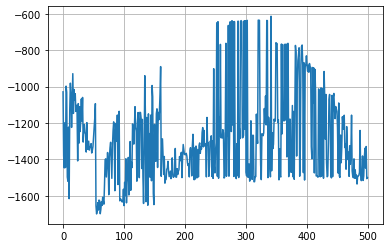

In [11]:
import matplotlib.pyplot as plt
def plot(a):
    plt.plot(np.array(a))
    plt.grid()
    plt.show()
plot(scores)